In [ ]:
widgets.Checkbox(
    value=False,
    description='Check me',
    disabled=False
)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import scipy
import time
import datetime
import csv
import pandas
import copy
import pickle
import math

from IPython.display import display, HTML

from sklearn.externals import joblib
from sklearn.pipeline import make_pipeline, make_union
import sklearn.linear_model
import sklearn.metrics
import sklearn.ensemble
#import xgboost
import sklearn.preprocessing
import sklearn.model_selection
from tqdm import tqdm_notebook
import tqdm

%matplotlib inline

import seaborn as sns
def setSnsStyle(style):
    sns.set(style=style, font_scale=1.5)
    font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 30}
    matplotlib.rc('font', **font)
    matplotlib.rcParams['xtick.labelsize'] = 16 
    matplotlib.rcParams['ytick.labelsize'] = 16
    matplotlib.rcParams['axes.titlesize'] = 16
    matplotlib.rcParams['axes.labelsize'] = 16
    
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'retina'

setSnsStyle("ticks")

In [2]:
import plotly.plotly as plotly
import plotly.figure_factory
plotly.offline.init_notebook_mode(connected=True)

ImportError: No module named 'plotly'

In [5]:
dance_events = pandas.read_hdf("/mnt/storage/david/cache/beesbook/foragergroups/full_data_marie23.hdf", "df")
dance_events = dance_events[dance_events.following == True]
candidate_recruits = pandas.read_hdf("/mnt/storage/david/cache/beesbook/foragergroups/recruit_dancer_candidates.hdf", "df")
candidate_recruits = candidate_recruits[candidate_recruits.from_s.str.startswith("2016/08/23")]
display(dance_events.head())
display(candidate_recruits.head())

,attending,author,begin,begin_frame_id,begin_timestamp,cam_id,comment,dancer,duration,end,...,video_duration,video_end_timestamp,videoname,begin_datetime,video_begin_datetime,end_datetime,video_end_datetime,video_date,begin_time,begin_time_hours
348,False,marie,13.0,13312884246722392064,1.471955e+09,1,NaN,NaN,26.245132,92.0,...,30.561865,1.471955e+09,2016-08-23 12_26_16.075_cam01_936-2691-2022_93...,2016-08-23 12:26:20.392044,2016-08-23 12:26:16.075311,2016-08-23 12:26:46.637176,2016-08-23 12:26:46.637176,2016-08-23,12:26:20.392044,12.4389
437,False,marie,5.0,13214857343454472192,1.471964e+09,2,NaN,918.0,13.955693,47.0,...,15.615811,1.471964e+09,2016-08-23 14/45/45.654_918_2691,2016-08-23 14:45:47.314633,2016-08-23 14:45:45.654515,2016-08-23 14:46:01.270326,2016-08-23 14:46:01.270326,2016-08-23,14:45:47.314633,14.7631
445,False,marie,1.0,16761203133459744768,1.471964e+09,2,NaN,918.0,12.956178,40.0,...,13.288159,1.471964e+09,2016-08-23 14/58/42.021_918_2691,2016-08-23 14:58:42.353965,2016-08-23 14:58:42.021984,2016-08-23 14:58:55.310143,2016-08-23 14:58:55.310143,2016-08-23,14:58:42.353965,14.9783
449,False,marie,88.0,12912866384377231360,1.471962e+09,2,NaN,918.0,14.617008,132.0,...,50.496965,1.471962e+09,2016-08-23 14_17_36.050_cam02_2854-2691-2022-9...,2016-08-23 14:18:05.286089,2016-08-23 14:17:36.050996,2016-08-23 14:18:19.903097,2016-08-23 14:18:26.547961,2016-08-23,14:18:05.286089,14.3014
450,False,marie,88.0,12912866384377231360,1.471962e+09,2,NaN,918.0,14.617008,132.0,...,50.496965,1.471962e+09,2016-08-23 14_17_36.050_cam02_2854-2691-2022-9...,2016-08-23 14:18:05.286089,2016-08-23 14:17:36.050996,2016-08-23 14:18:19.903097,2016-08-23 14:18:26.547961,2016-08-23,14:18:05.286089,14.3014


,dancer,from,from_s,recruit,to,to_s
12,918,1.471932e+09,2016/08/23 06:00,119,1.471975e+09,2016/08/23 18:00
13,1017,1.471932e+09,2016/08/23 06:00,119,1.471975e+09,2016/08/23 18:00
14,1883,1.471932e+09,2016/08/23 06:00,119,1.471975e+09,2016/08/23 18:00
15,2122,1.471932e+09,2016/08/23 06:00,119,1.471975e+09,2016/08/23 18:00
16,3178,1.471932e+09,2016/08/23 06:00,119,1.471975e+09,2016/08/23 18:00


In [6]:
all_bees_of_interest = set(candidate_recruits.dancer.values) | set(candidate_recruits.recruit.values)
print ("{} interesting bees to check.".format(len(all_bees_of_interest)))

14 interesting bees to check.


In [7]:
earliest_dance = np.nanmin(dance_events.begin_timestamp)
latest_dance   = np.nanmax(dance_events.end_timestamp)
ts_from = float(earliest_dance - 60 * 60.0)
ts_to = float(latest_dance + 60 * 60.0)
#ts_from = datetime.datetime.utcfromtimestamp(ts_from)
#ts_to = datetime.datetime.utcfromtimestamp(ts_to)

In [8]:
import bb_binary
repository = bb_binary.Repository("/mnt/storage/beesbook-data-clean/pipeline_data/repo_season_2016_fixed/")
#repository = bb_binary.Repository("/mnt/storage/beesbook-data-clean/beesbook-data-clean/pipeline_data/repo_season_2016_fixed")

In [9]:
import bb_utils.ids

In [10]:
all_bees_of_interest

{119,
 918,
 936,
 1017,
 1883,
 2022,
 2122,
 2508,
 2691,
 2772,
 2854,
 3069,
 3178,
 3831}

In [50]:
len(bee_detections[119])

3

In [54]:
bee_detections = {}
for bee in all_bees_of_interest:
    bee_detections[bee] = ([], [], [])
matches = 0
for camID in tqdm.tqdm_notebook(range(4)):
    trange = tqdm.tqdm_notebook(repository.iter_frames(begin=ts_from, end=ts_to, cam=camID))
    for frame, fc in trange:
        frame_timestamp = frame.timestamp
        for detection in frame.detectionsUnion.detectionsDP:
            #LENS.append(len(list(detection.decodedId)))
            #print (len(list(detection.decodedId)), detection.decodedId)
            #continue
            ID = np.array(detection.decodedId)
            confidence = np.min(np.abs(ID / 255. - 0.5) * 2.0)
            decoded_id_dec = bb_utils.ids.BeesbookID.from_bb_binary(ID >= 128).as_dec_12()
            
            if not decoded_id_dec in all_bees_of_interest:
                continue
            matches += 1
            trange.set_description("{} matches found.".format(matches))
            res = bee_detections[decoded_id_dec]
            res[0].append(frame_timestamp)
            res[1].append(camID)
            res[2].append(confidence)
with open("/mnt/storage/david/cache/beesbook/foragergroups/bee_detections23.pickle", "wb") as f:
    pickle.dump(bee_detections, f)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [21]:
with open("/mnt/storage/david/cache/beesbook/foragergroups/bee_detections23.pickle", "rb") as f:
    bee_detections = pickle.load(f)

In [51]:
for bee in bee_detections:
    data = [bee_detections[bee][0], bee_detections[bee][1], bee_detections[bee][2]]
    data[0] = np.array(data[0])
    data[1] = np.array(data[1])
    data[2] = np.array(data[2])
    sort_indices = np.argsort(data[0])
    data[0] = data[0][sort_indices]
    data[1] = data[1][sort_indices]
    data[2] = data[2][sort_indices]
    
    bee_detections[bee] = {
        "timestamps": data[0],
        "cam_ids": data[1],
        "diff": np.diff(data[0]),
        "confidence": data[2]
    }
    print("bee {:6d}\t timestamps: {}\tmax diff: {}".format(bee, len(data[0]), np.max(bee_detections[bee]["diff"])))

bee   2691	 timestamps: 13665	max diff: 513.692467928
bee   2022	 timestamps: 11927	max diff: 246.620272875
bee   2854	 timestamps: 15268	max diff: 402.795853138
bee    936	 timestamps: 21299	max diff: 246.703064919
bee   2122	 timestamps: 1131	max diff: 530.74166894
bee   3831	 timestamps: 56470	max diff: 82.0539939404
bee   2508	 timestamps: 16181	max diff: 498.305639029
bee   2772	 timestamps: 41500	max diff: 299.491849184
bee   3178	 timestamps: 22434	max diff: 368.521111965
bee    918	 timestamps: 11656	max diff: 347.956606865
bee    119	 timestamps: 18760	max diff: 263.106474876
bee   1017	 timestamps: 1193	max diff: 207.461086035
bee   1883	 timestamps: 4478	max diff: 262.436672926
bee   3069	 timestamps: 18505	max diff: 339.513422012


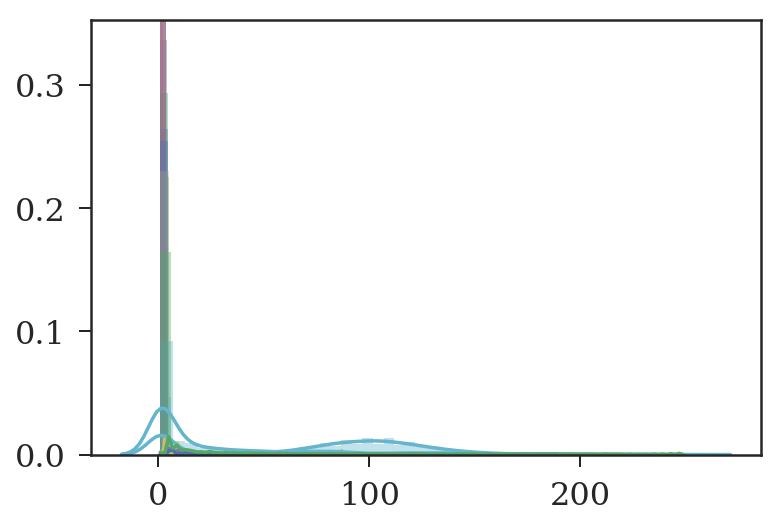

In [53]:
for bee, data in bee_detections.iteritems():
    sns.distplot(data["confidence"])

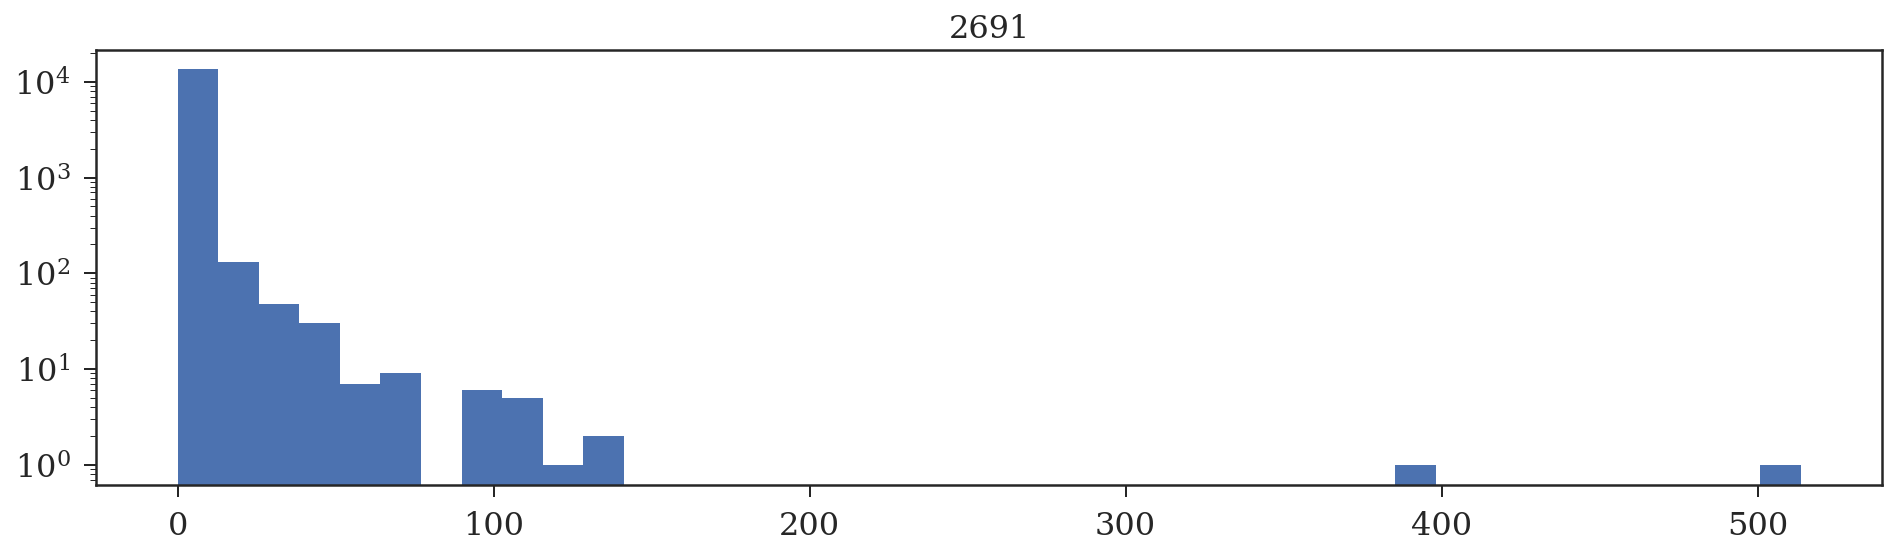

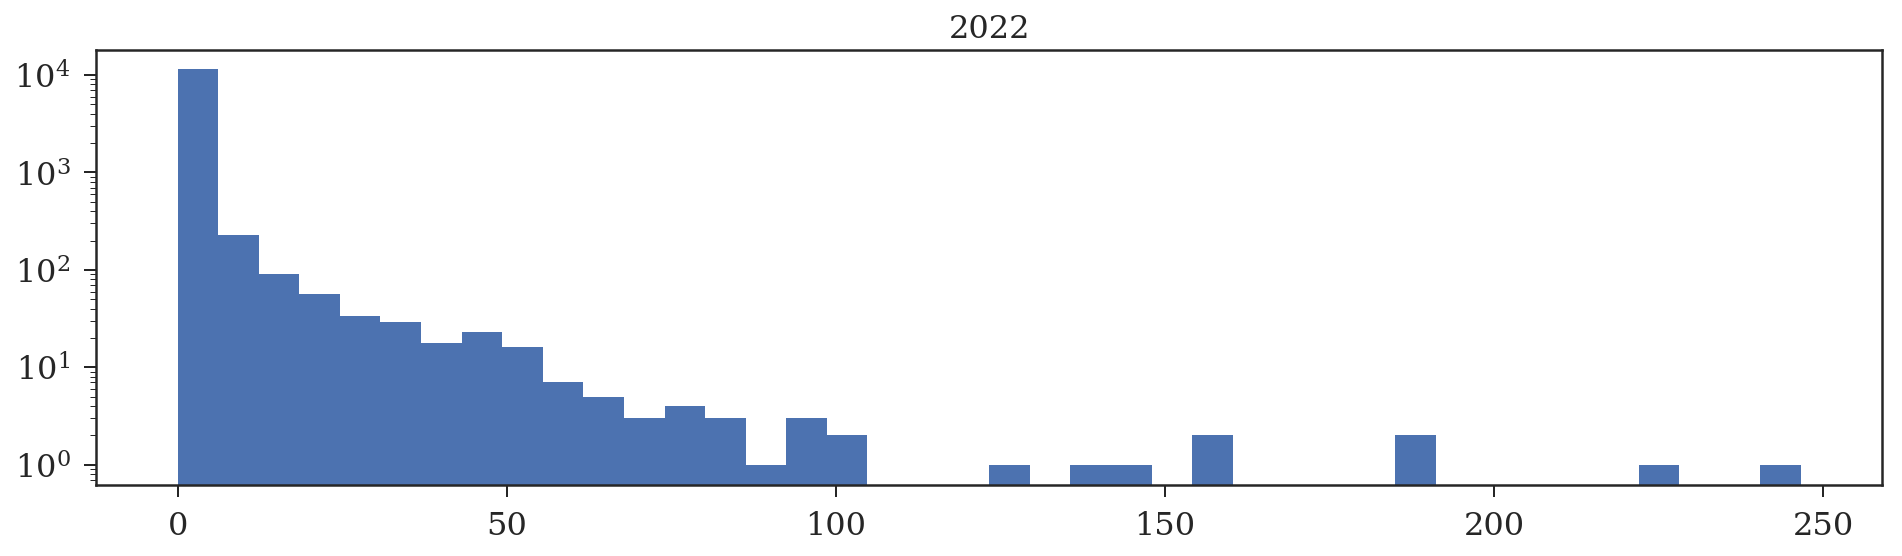

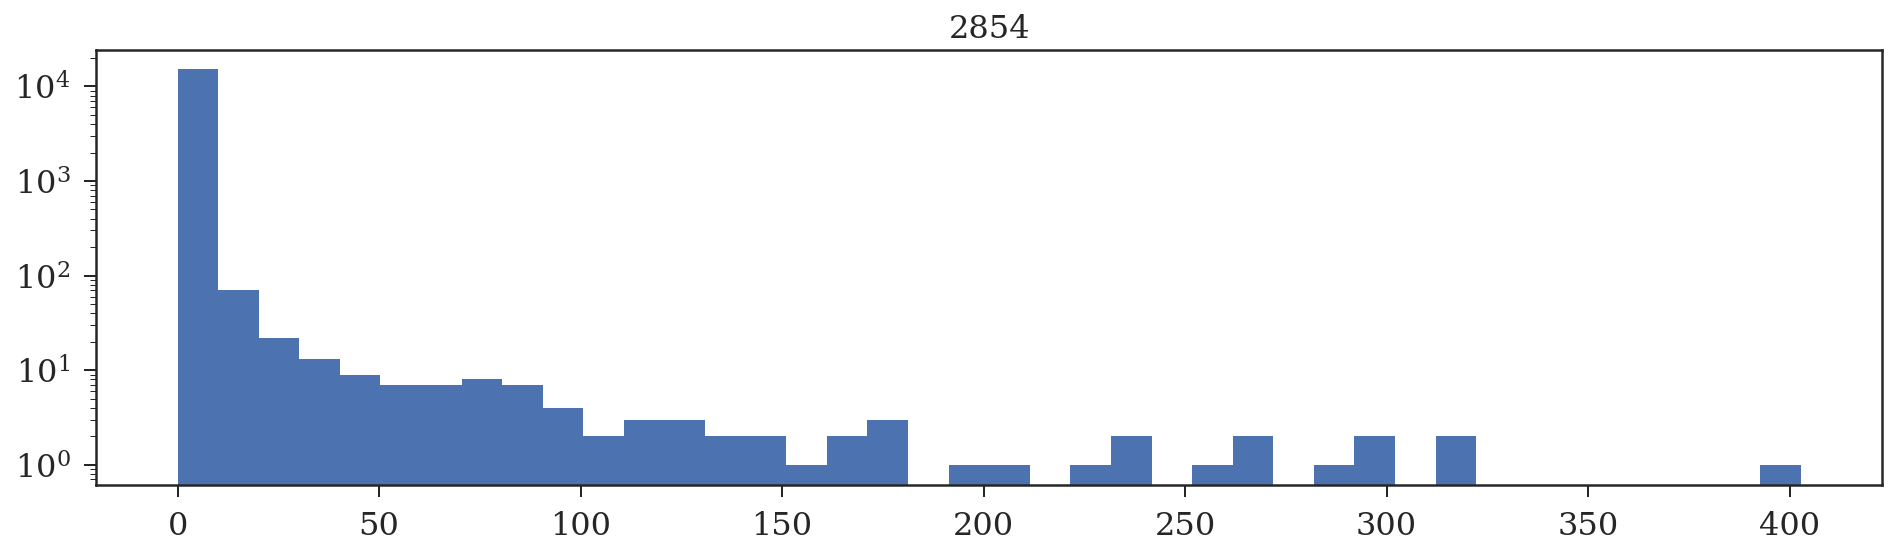

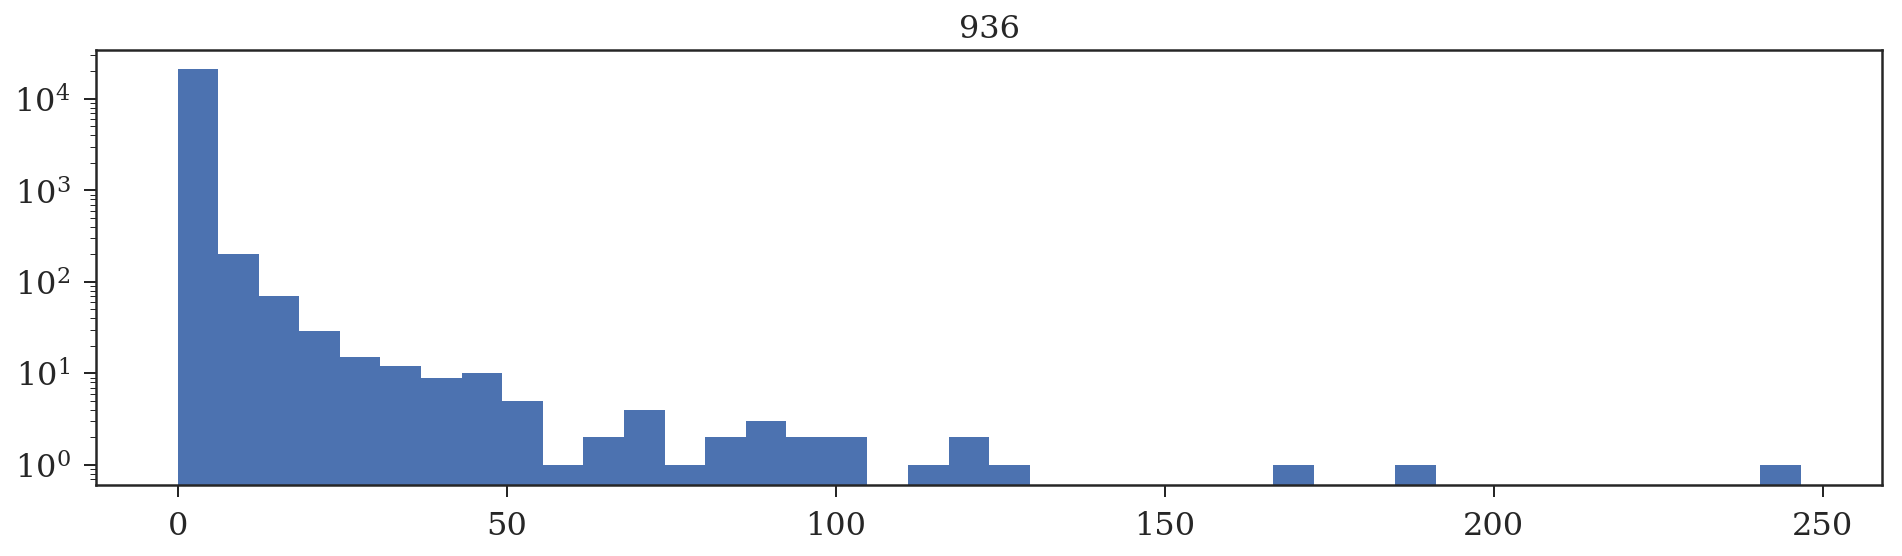

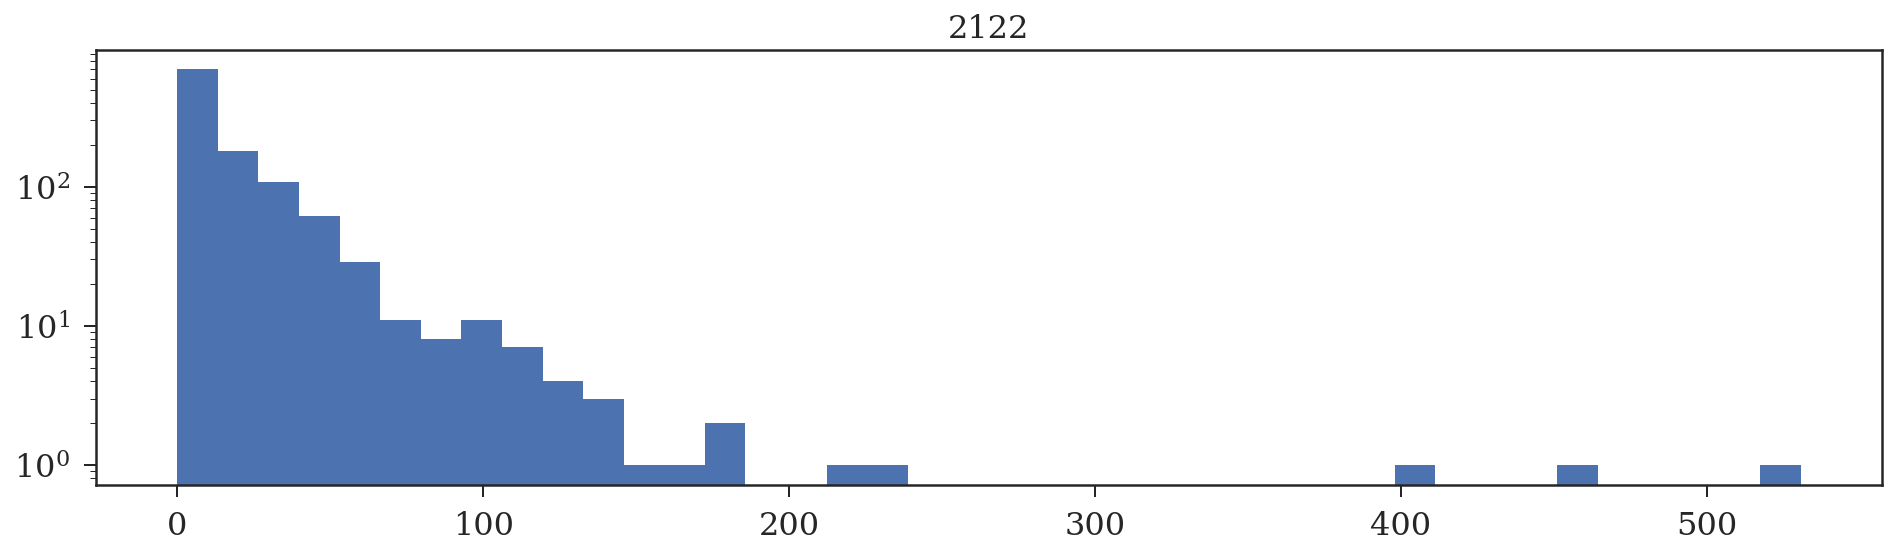

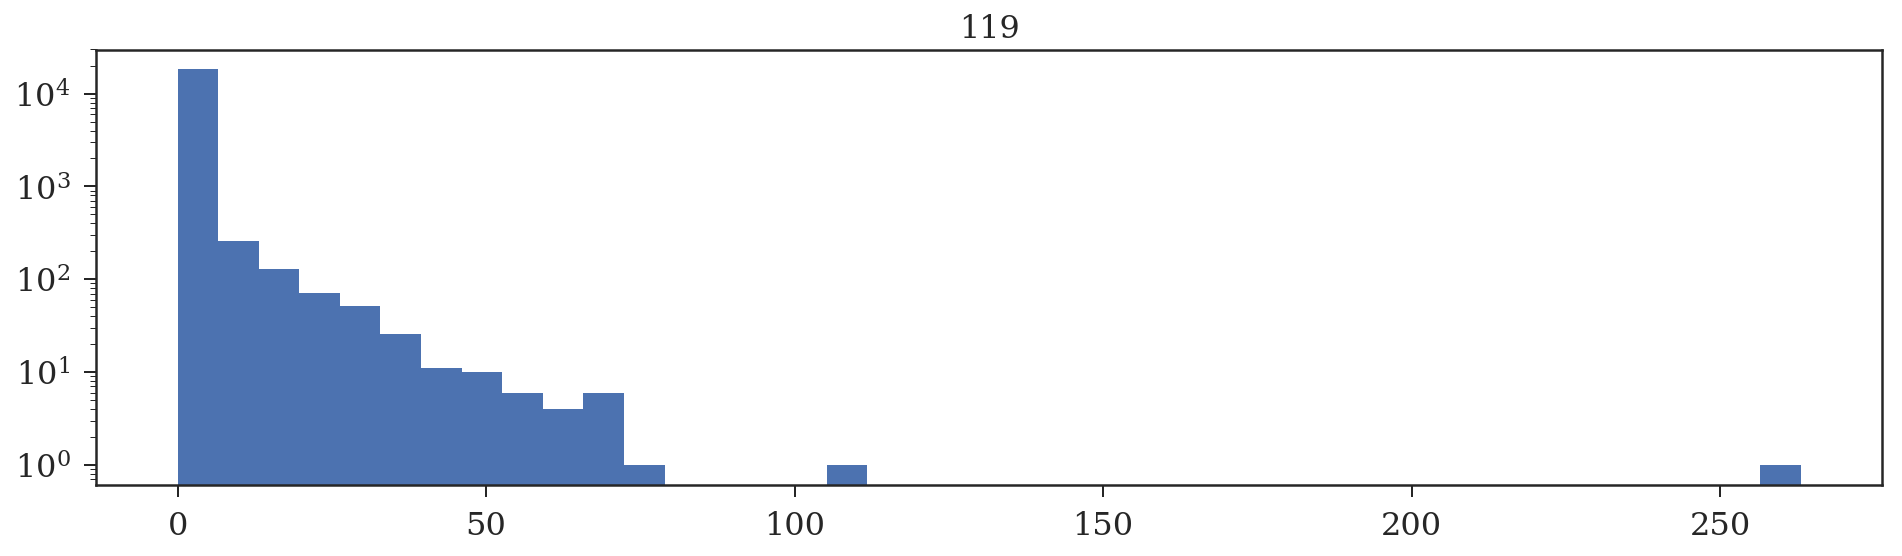

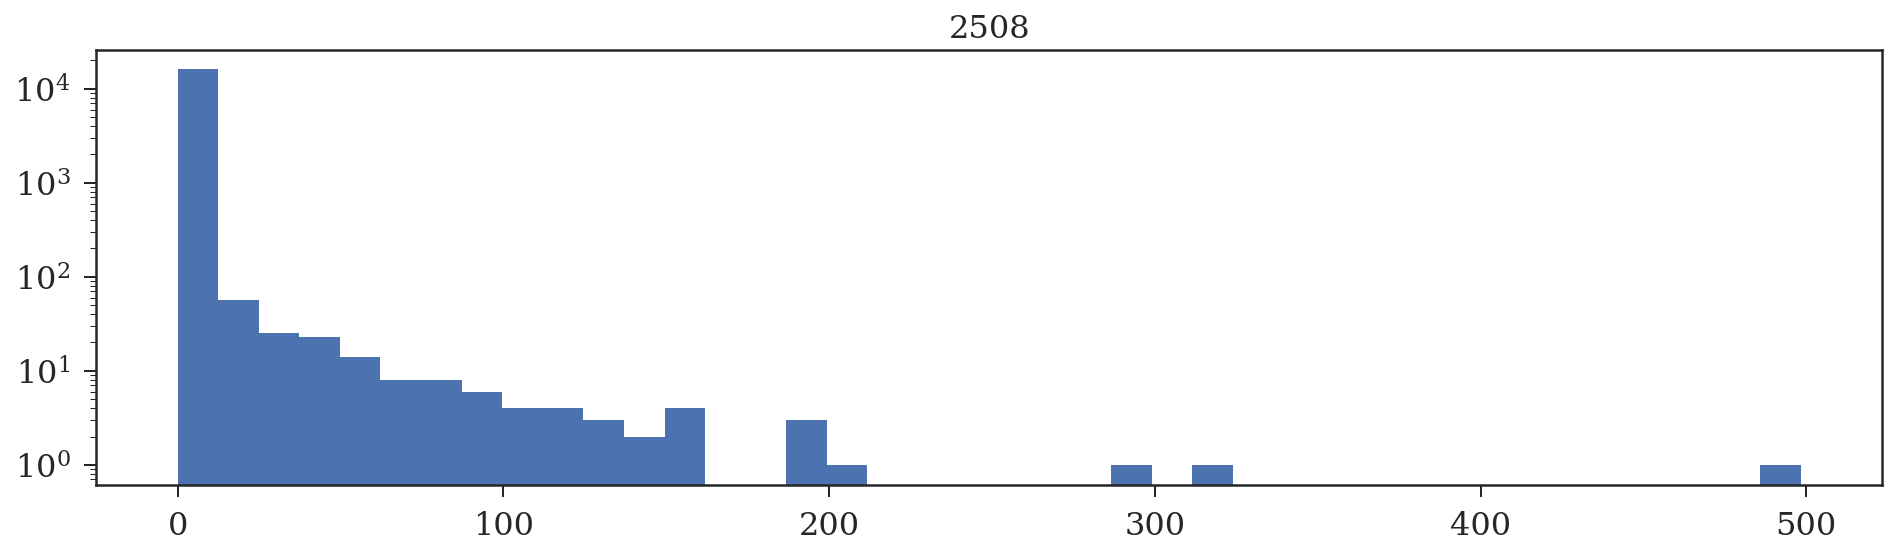

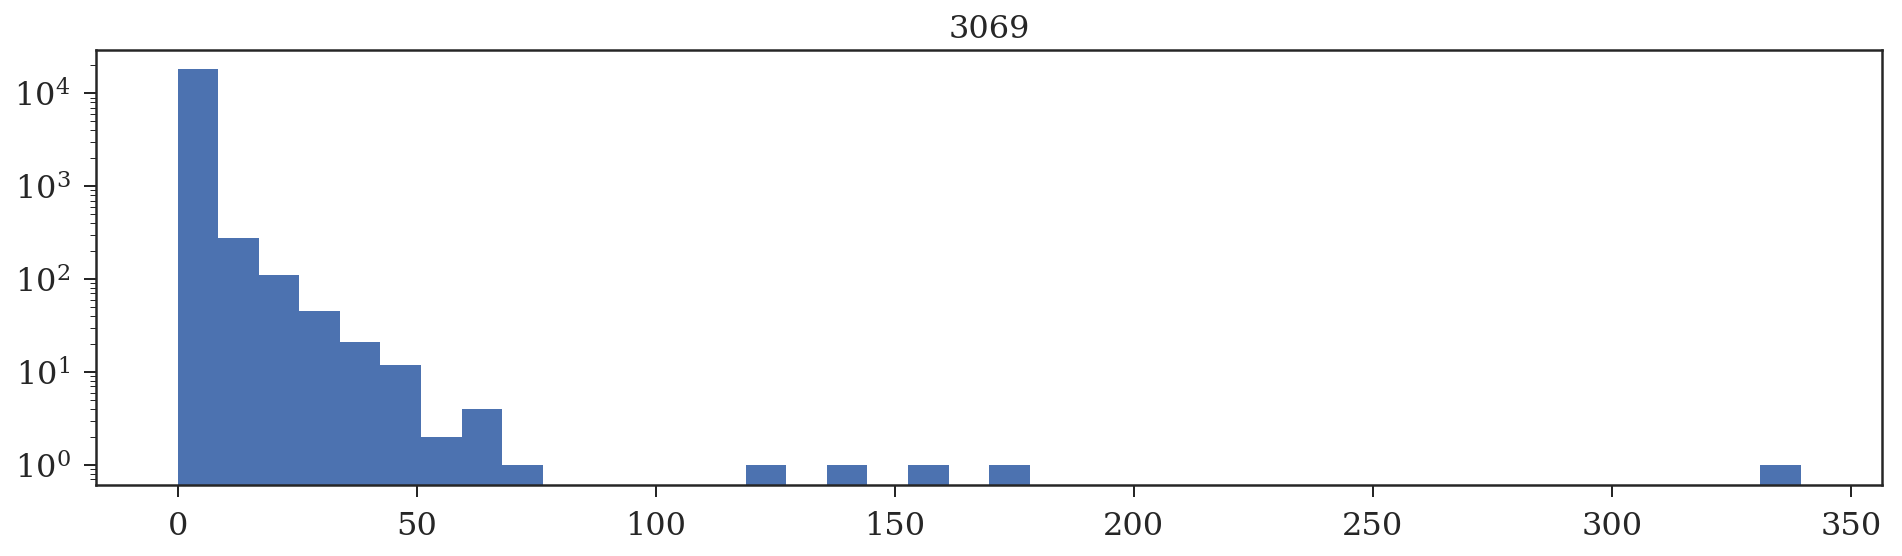

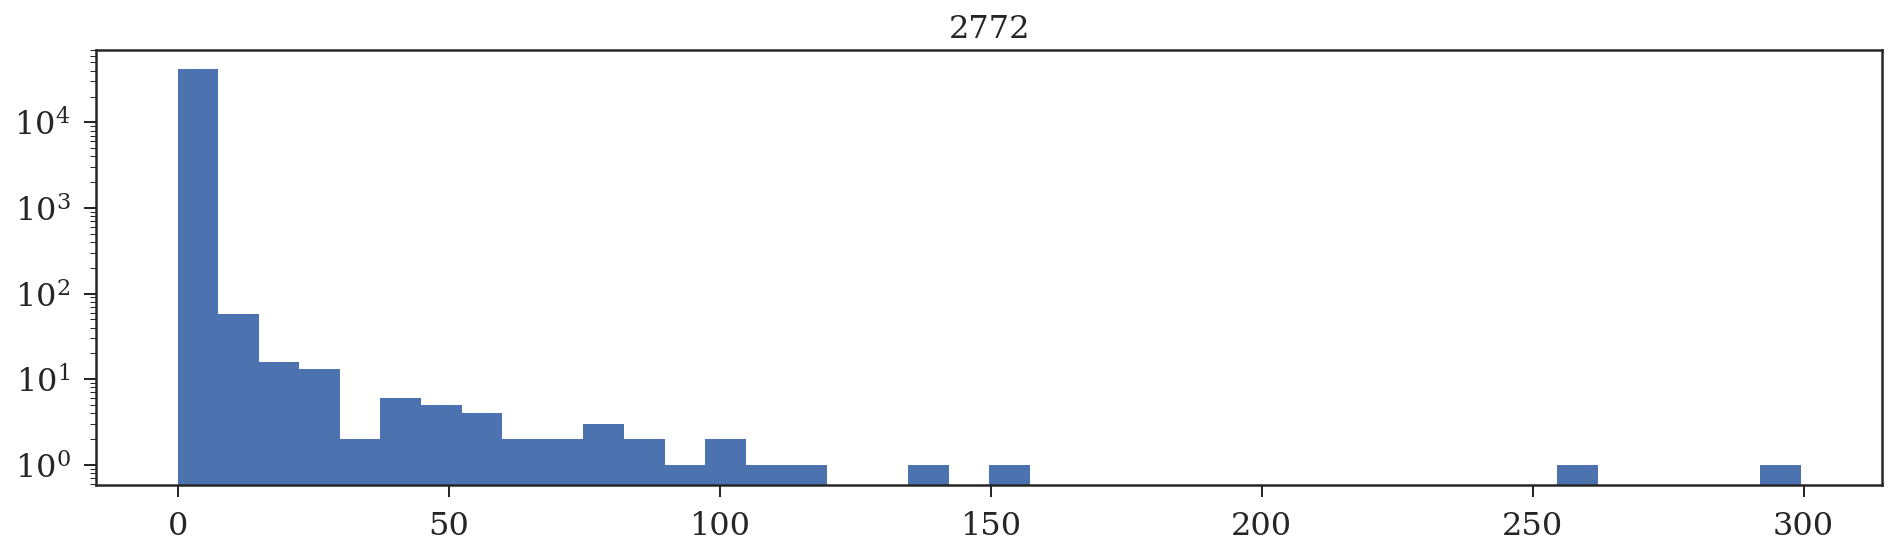

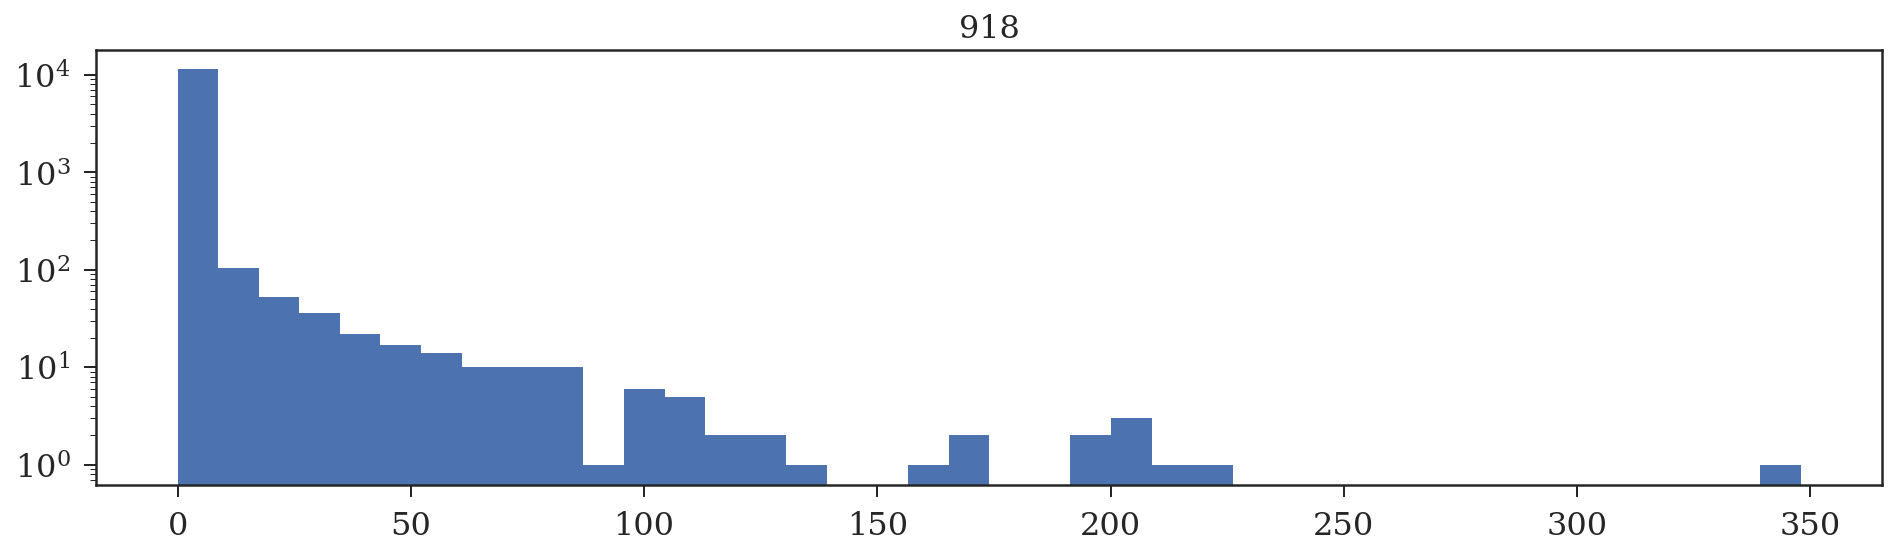

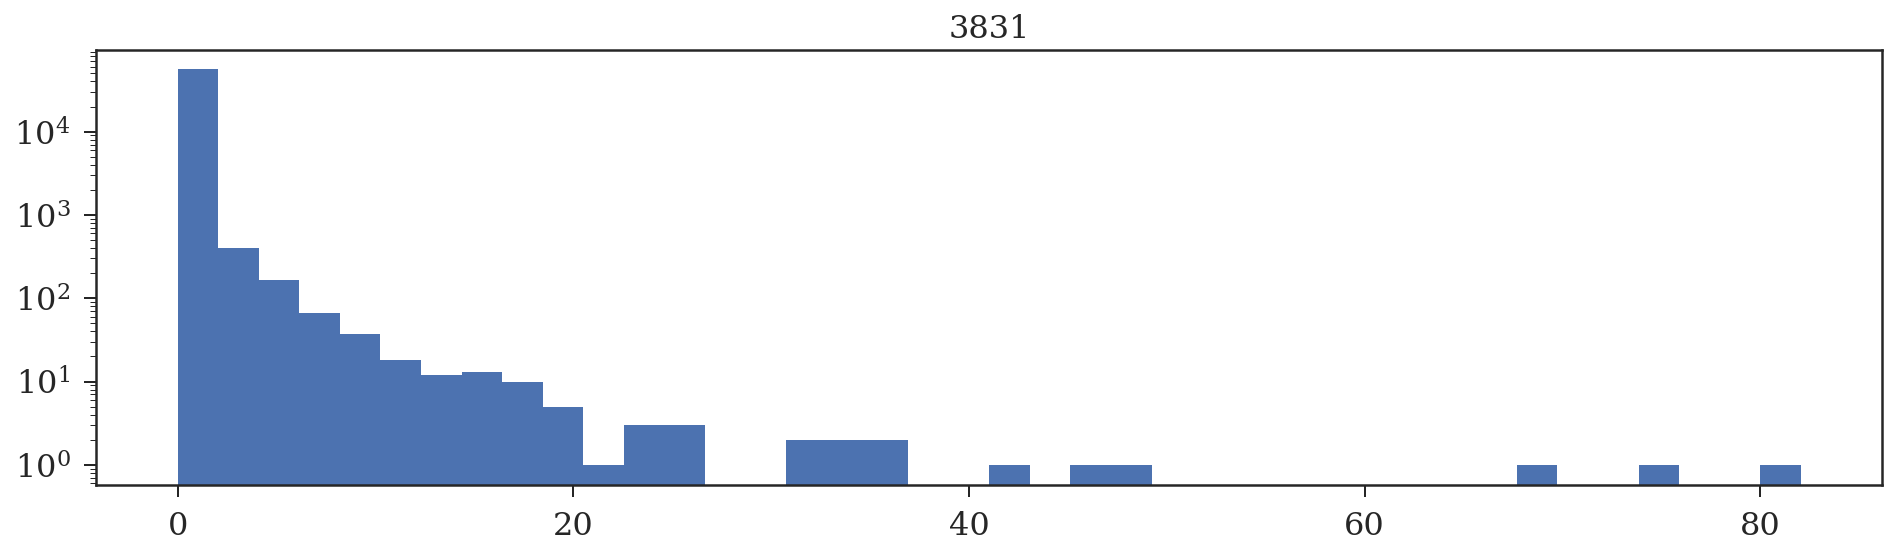

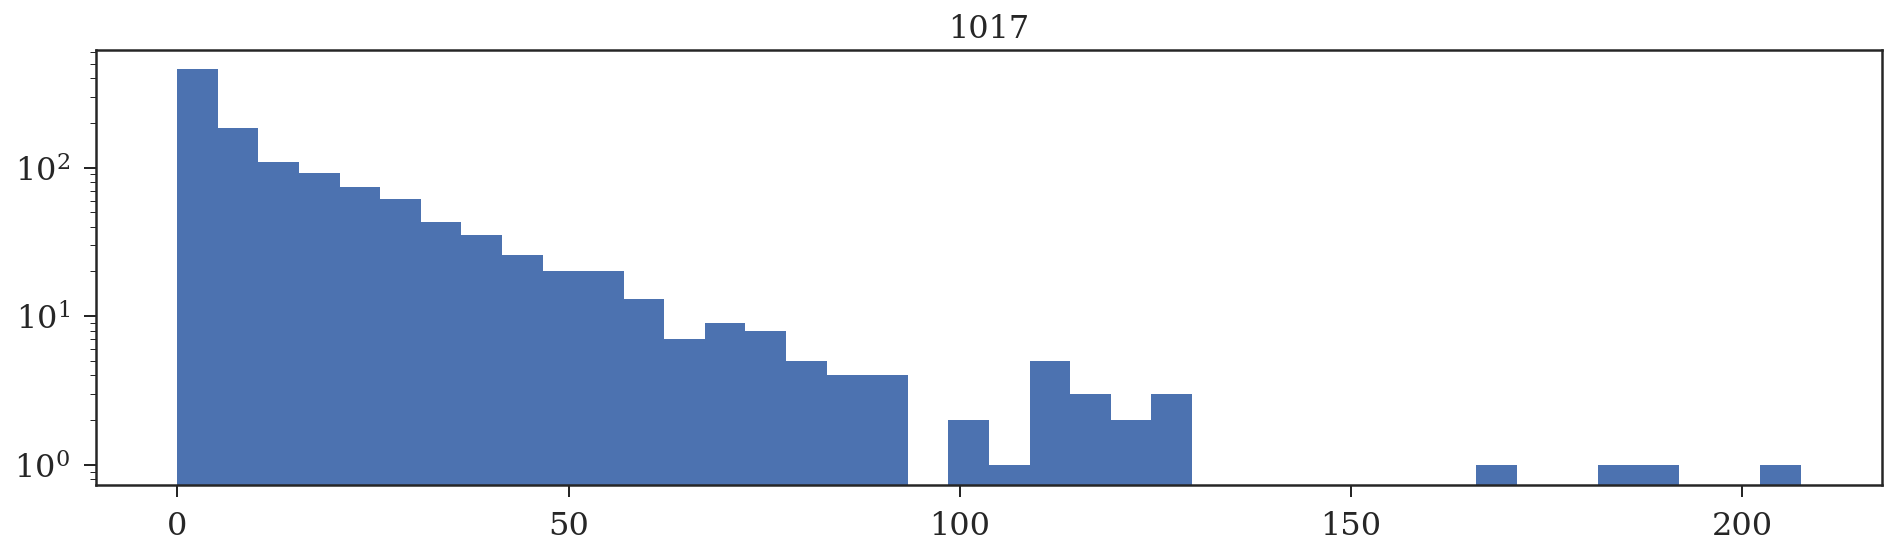

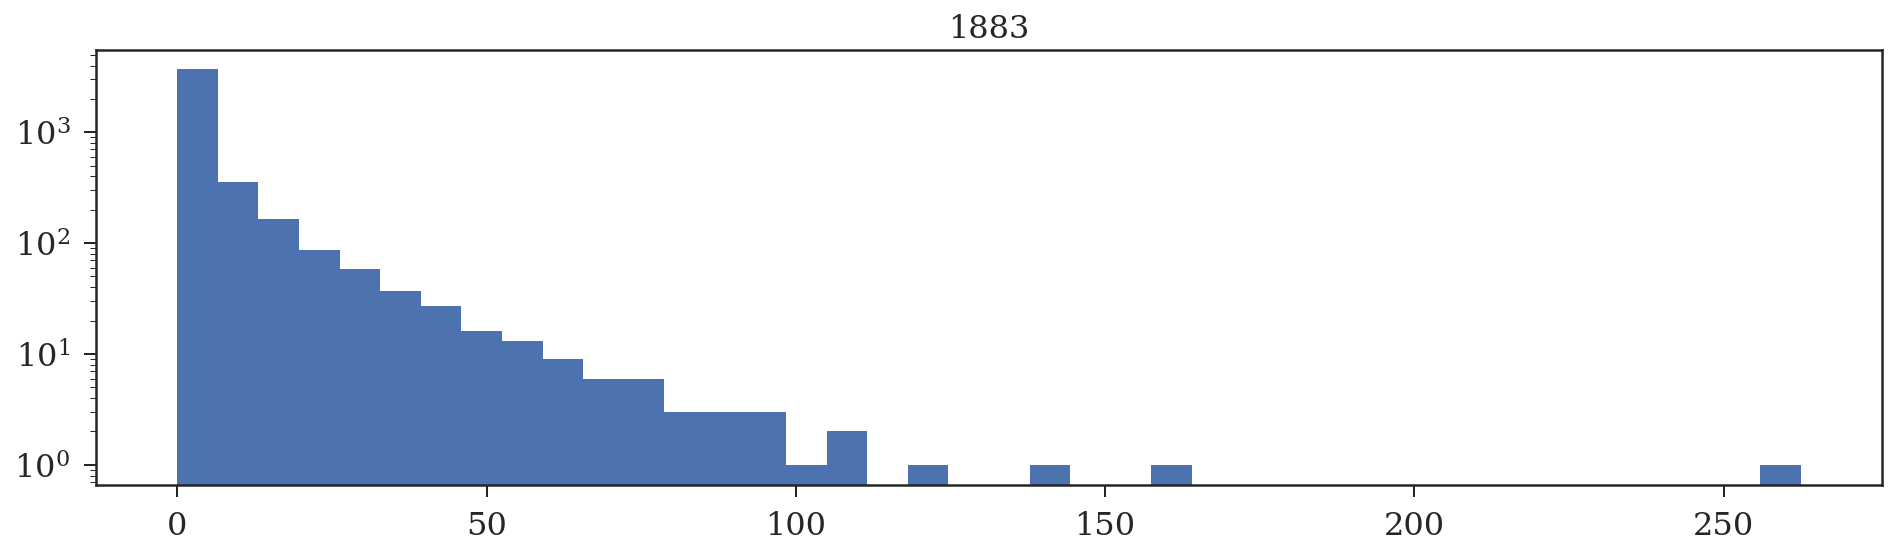

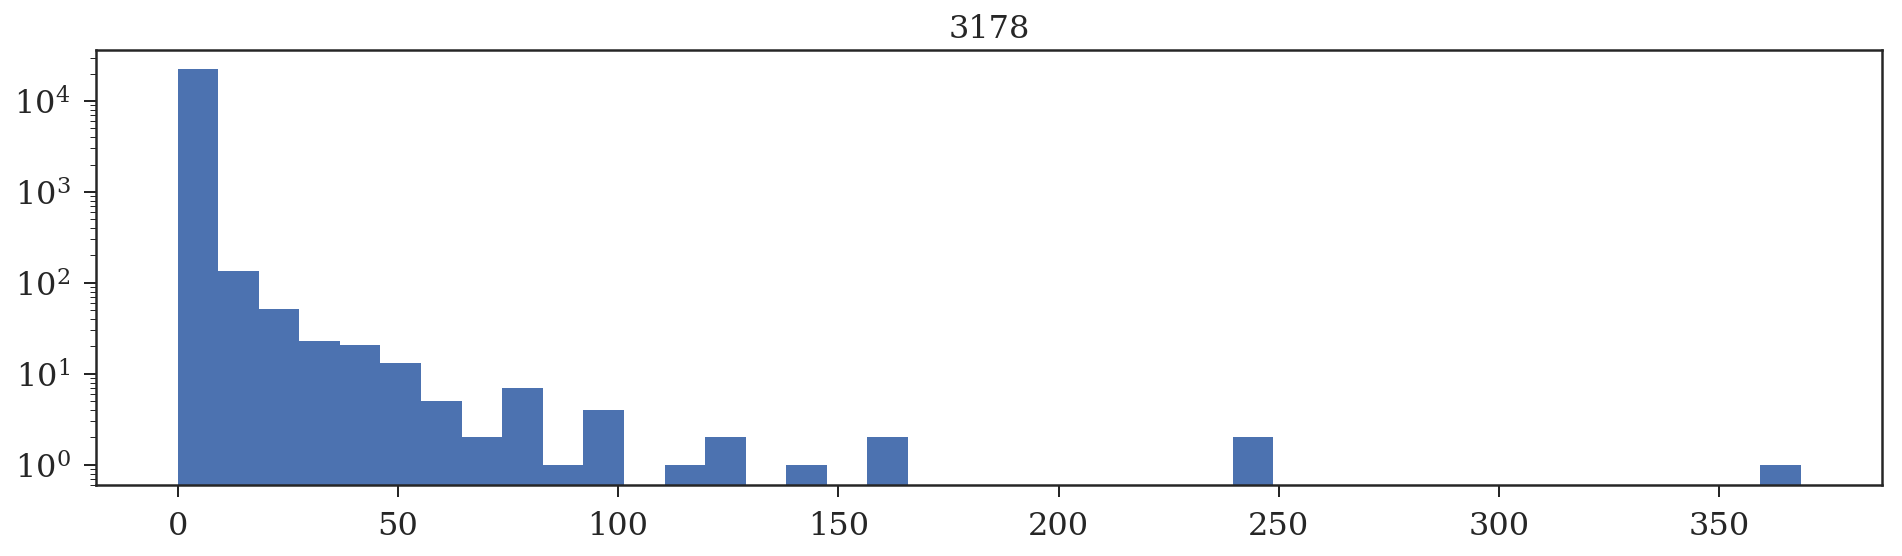

In [23]:
for bee, data in bee_detections.iteritems():
    fig, ax = plt.subplots(1, 1, figsize=(16, 4))
    plt.hist(data["diff"], bins=40, log=True)
    plt.title(str(bee))
    #plt.semilogy()
    plt.show()

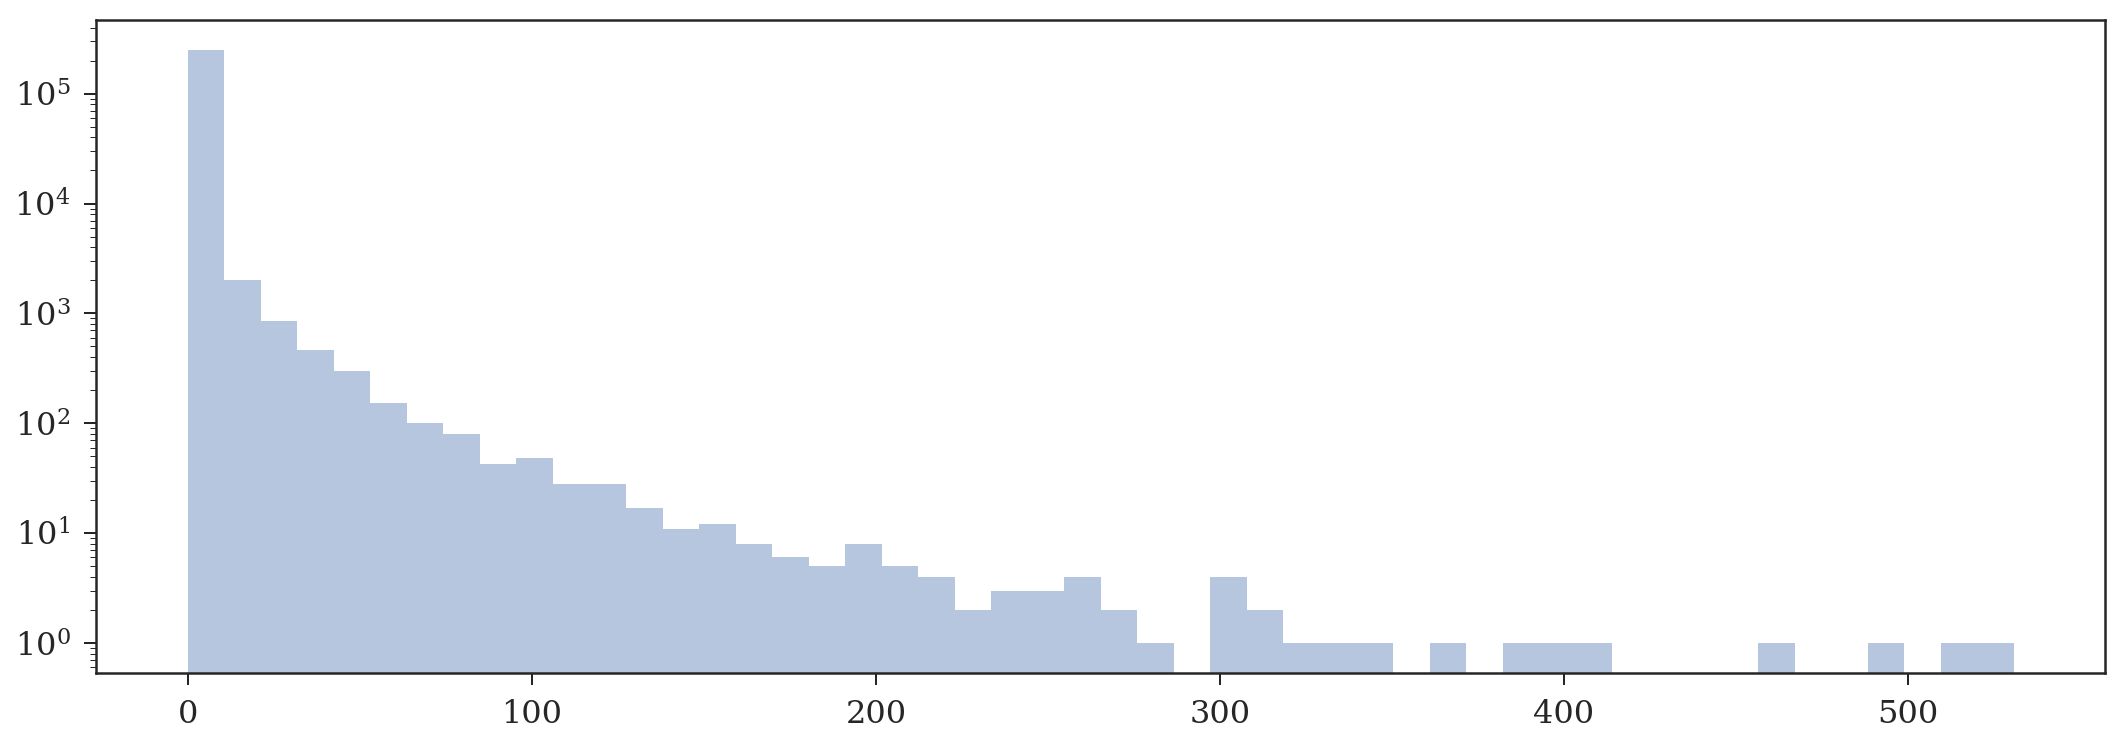

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
sns.distplot(np.hstack([d["diff"] for (b,d) in bee_detections.iteritems()]), ax=ax, hist_kws={"log":True}, kde=False)
plt.show()

In [25]:
GAP_DURATION = 120

In [26]:
for bee, data in bee_detections.iteritems():
    data["gaps"] = []
    gaps = np.where(data["diff"] > GAP_DURATION)[0]
    for gap in gaps:
        data["gaps"].append((data["timestamps"][gap], data["timestamps"][gap + 1]))
    print ("bee {:5d}: {:3d} gaps".format(bee, len(data["gaps"])))
gaps_df = []
for bee, data in bee_detections.iteritems():
    for begin, end in data["gaps"]:
        gaps_df.append((bee, begin, end))
gaps_df = pandas.DataFrame(gaps_df, columns=("bee", "begin", "end"))
gaps_df.to_hdf("/mnt/storage/david/cache/beesbook/foragergroups/bee_gaps23.hdf", "df")
gaps_df.describe()

bee  2691:   5 gaps
bee  2022:   9 gaps
bee  2854:  28 gaps
bee   936:   5 gaps
bee  2122:  16 gaps
bee   119:   1 gaps
bee  2508:  19 gaps
bee  3069:   5 gaps
bee  2772:   4 gaps
bee   918:  14 gaps
bee  3831:   0 gaps
bee  1017:   9 gaps
bee  1883:   4 gaps
bee  3178:   8 gaps


,bee,begin,end
count,127.000000,1.270000e+02,1.270000e+02
mean,2199.700787,1.471961e+09,1.471961e+09
std,778.829528,5.633171e+03,5.614911e+03
min,119.000000,1.471952e+09,1.471952e+09
25%,1883.000000,1.471956e+09,1.471956e+09
50%,2508.000000,1.471959e+09,1.471959e+09
75%,2854.000000,1.471966e+09,1.471966e+09
max,3178.000000,1.471972e+09,1.471972e+09


In [27]:
for bee, data in bee_detections.iteritems():
    data["presence"] = []
    gaps = np.where(data["diff"] > GAP_DURATION)[0]
    presence_start = data["timestamps"][0]
    for gap in gaps:
        presence_end = data["timestamps"][gap]
        data["presence"].append((presence_start, presence_end))
        presence_start = data["timestamps"][gap + 1]
    
    data["presence"].append((presence_start, data["timestamps"][-1]))
    print ("bee {:5d}: {:3d} presences".format(bee, len(data["presence"])))
presence_df = []
for bee, data in bee_detections.iteritems():
    for begin, end in data["presence"]:
        presence_df.append((bee, begin, end))
presence_df = pandas.DataFrame(presence_df, columns=("bee", "begin", "end"))
presence_df.to_hdf("/mnt/storage/david/cache/beesbook/foragergroups/bee_presence23.hdf", "df")
presence_df.describe()

bee  2691:   6 presences
bee  2022:  10 presences
bee  2854:  29 presences
bee   936:   6 presences
bee  2122:  17 presences
bee   119:   2 presences
bee  2508:  20 presences
bee  3069:   6 presences
bee  2772:   5 presences
bee   918:  15 presences
bee  3831:   1 presences
bee  1017:  10 presences
bee  1883:   5 presences
bee  3178:   9 presences


,bee,begin,end
count,141.000000,1.410000e+02,1.410000e+02
mean,2193.489362,1.471960e+09,1.471962e+09
std,806.202373,6.042627e+03,6.385994e+03
min,119.000000,1.471952e+09,1.471952e+09
25%,1883.000000,1.471956e+09,1.471956e+09
50%,2508.000000,1.471958e+09,1.471961e+09
75%,2854.000000,1.471965e+09,1.471968e+09
max,3831.000000,1.471972e+09,1.471973e+09
